In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
import pandas as pd
import scipy as sp

In [2]:
WS = pd.read_excel('./Dados_C100_patricio.xlsx')
df_c100 = ps.DataFrame(WS)

WS = pd.read_excel('./Tensão_vs_SoC_C100.xlsx')
df_soc = ps.DataFrame(WS)

In [3]:
points = [
	[36,1116],
	[17299,22819],
	[34586,40106],
	[51912,57432],
	[69298,74818],
	[86728,92248],
	[104172,109692],
	[121666,127186],
	[139361,144881],
	[157114,162634]
]

In [4]:
def modelo_2rc(t, v0, v1, v2, t1, t2):
    return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)

In [5]:
def get_t_v(p1, df):
    p1, p2 = p1, p1+200
    corrente = df['Corrente [A]'][p1-1]
    df_teste = df[p1:p2][['Tempo [s]', 'Tensão [V]']].clone()
    df_teste = df_teste.select([ps.col('Tempo [s]').alias('t'), ps.col('Tensão [V]').alias('v')])
    df_teste['t'] = df_teste['t']-df_teste['t'][0]
    df_teste['v'] = df_teste['v']-df_teste['v'][0]
    t = df_teste['t'].to_numpy()
    v = df_teste['v'].to_numpy()
    return t, v, corrente

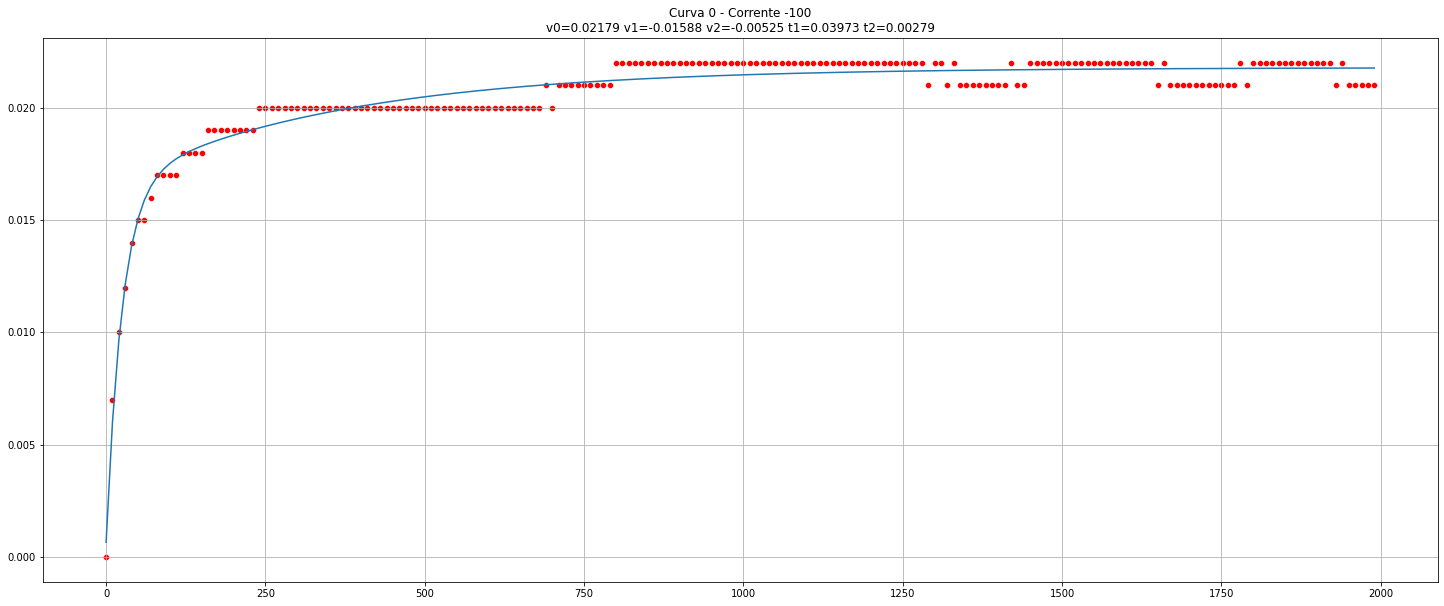

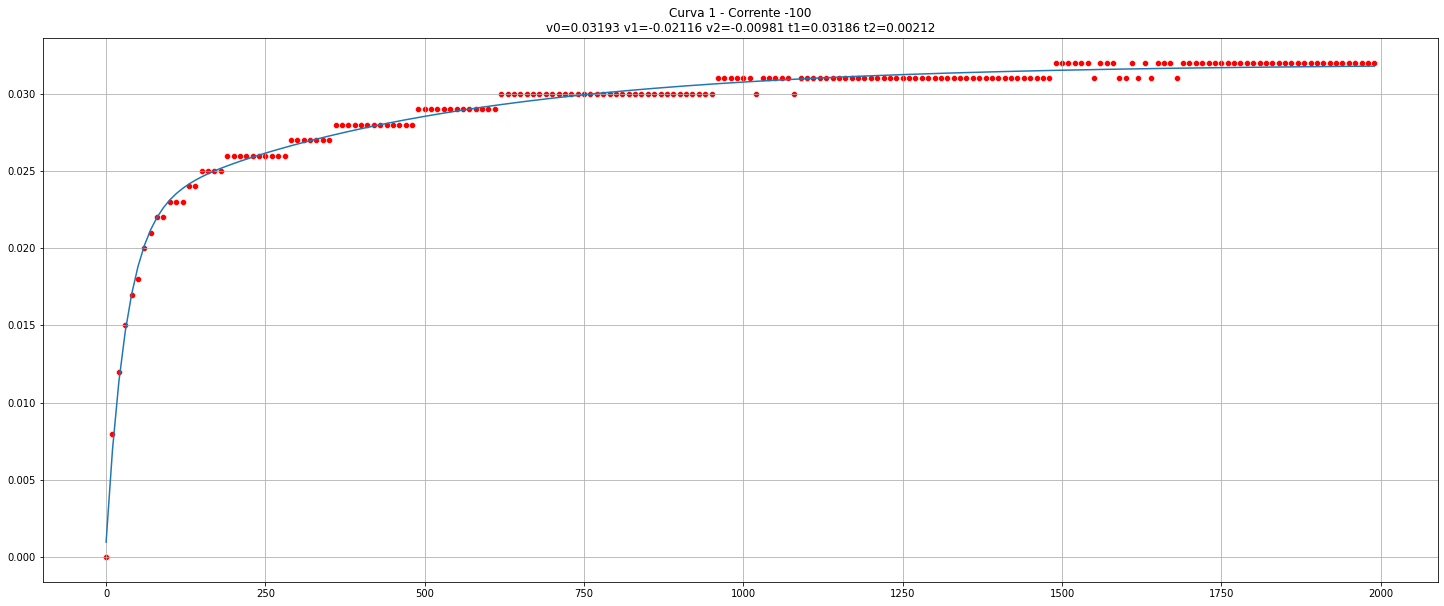

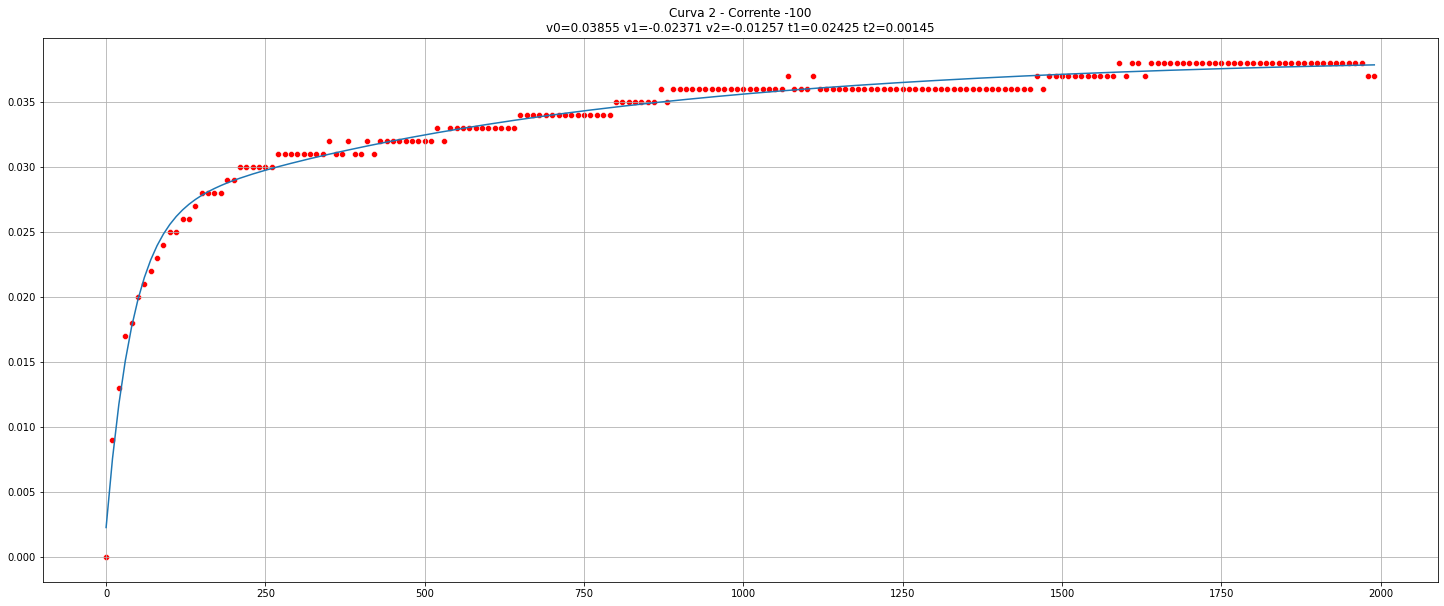

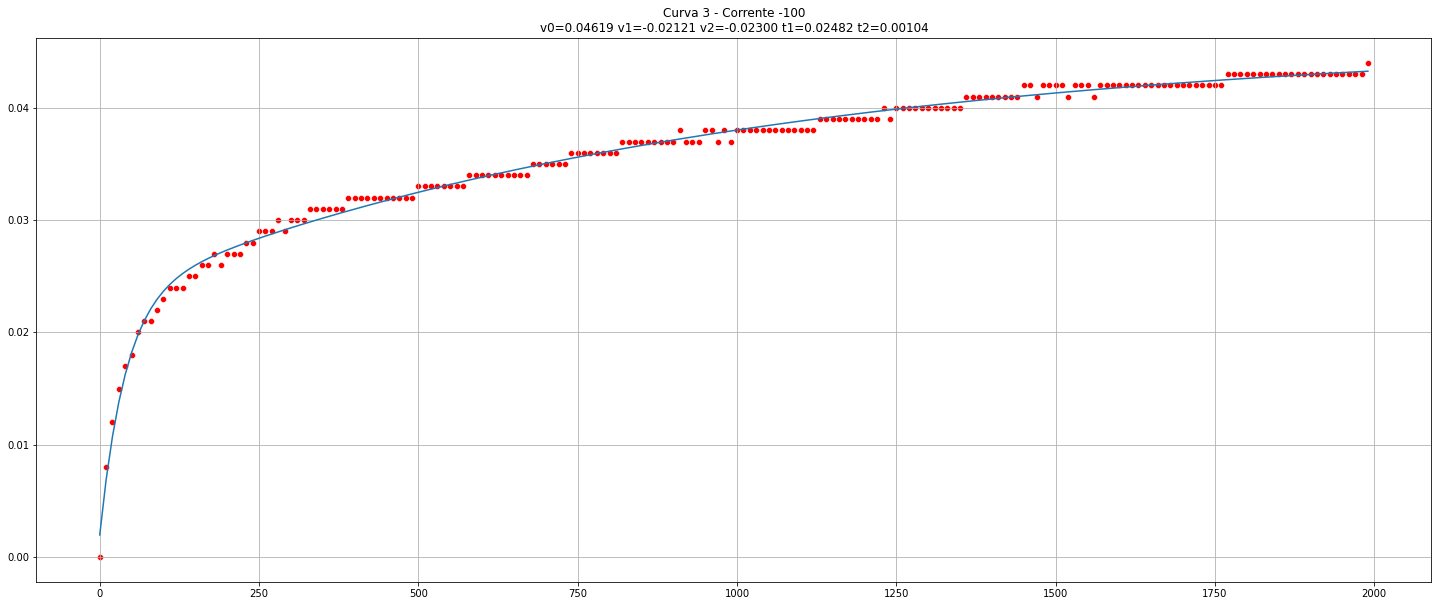

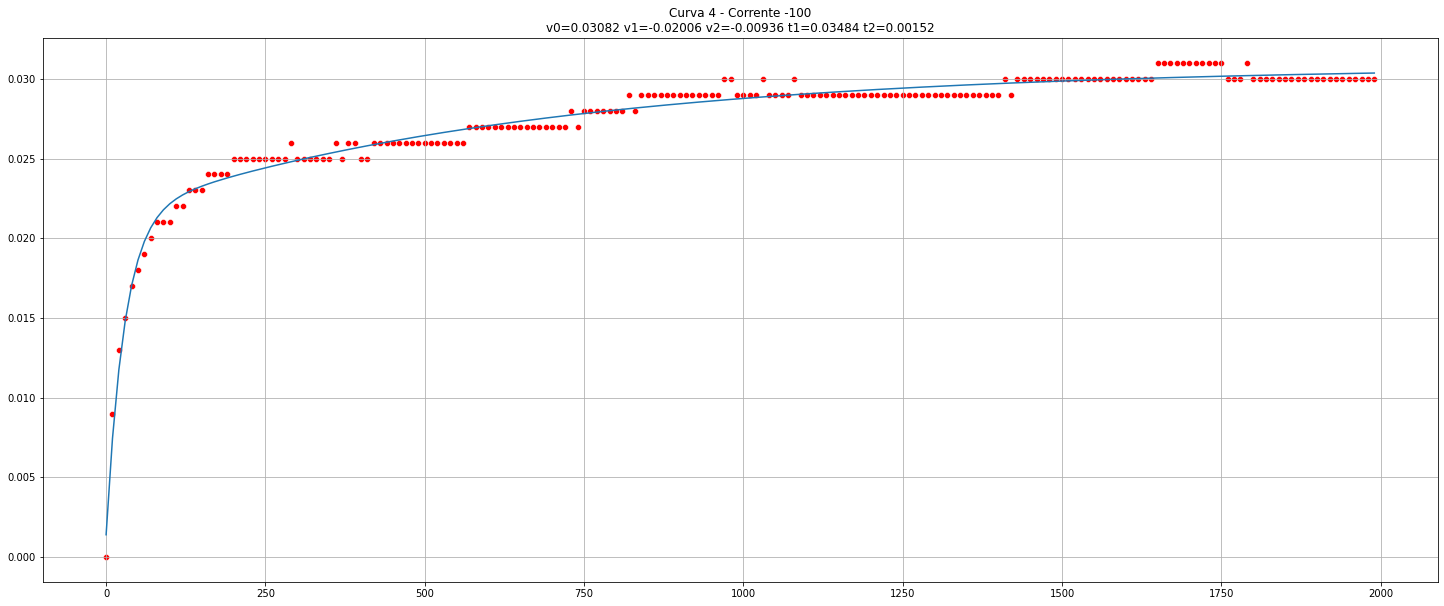

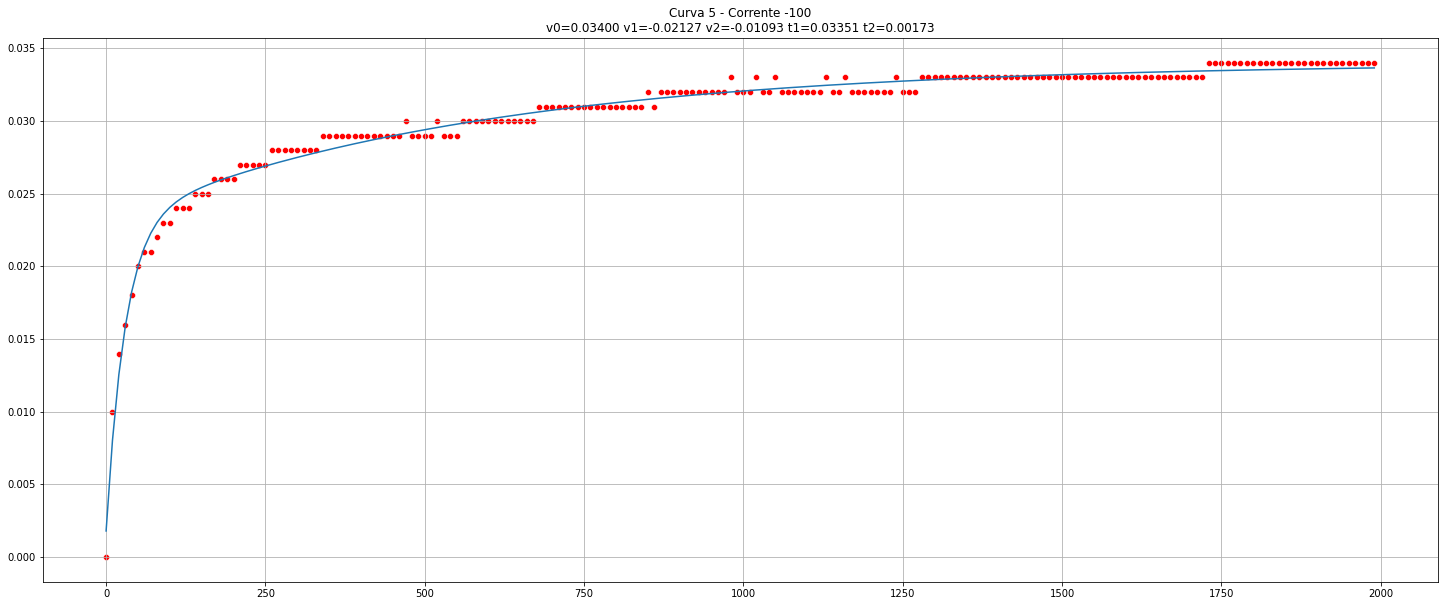

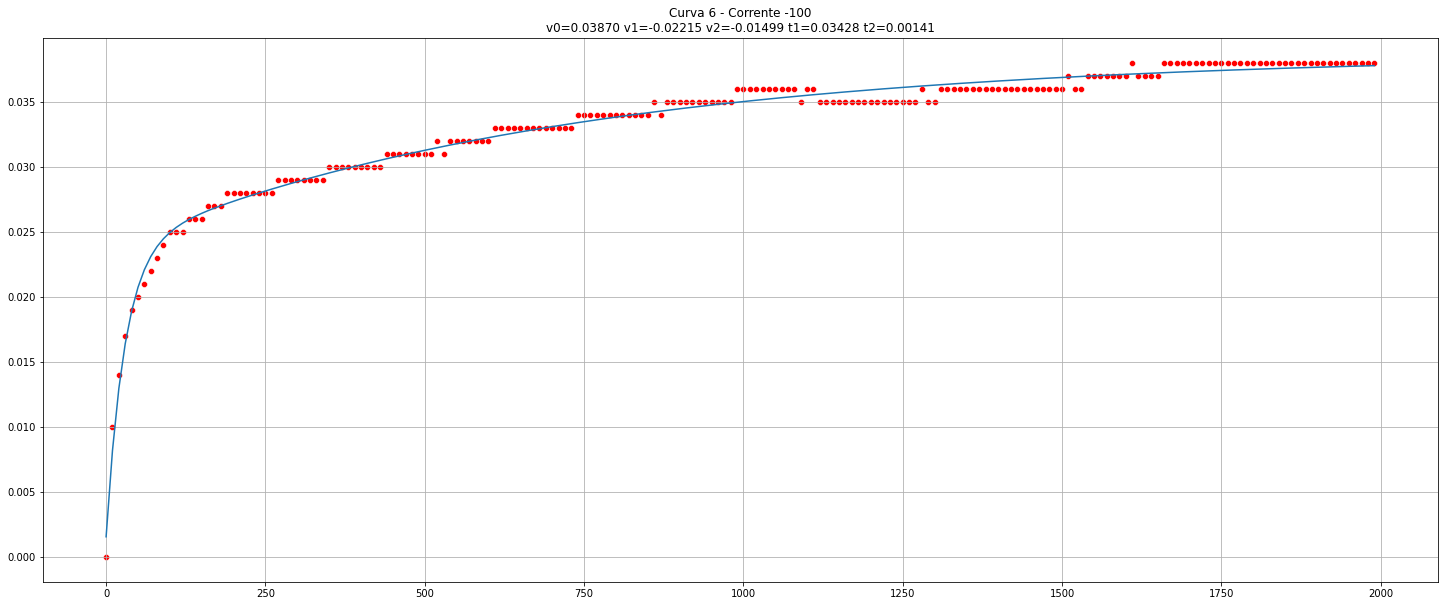

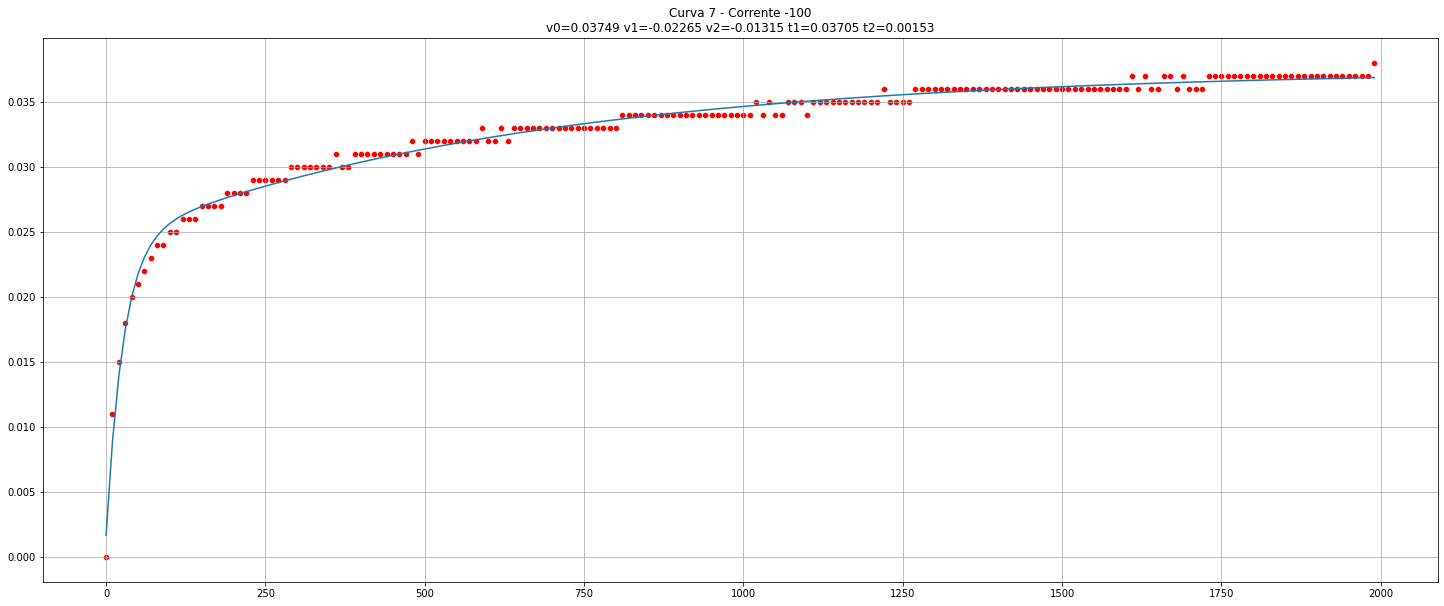

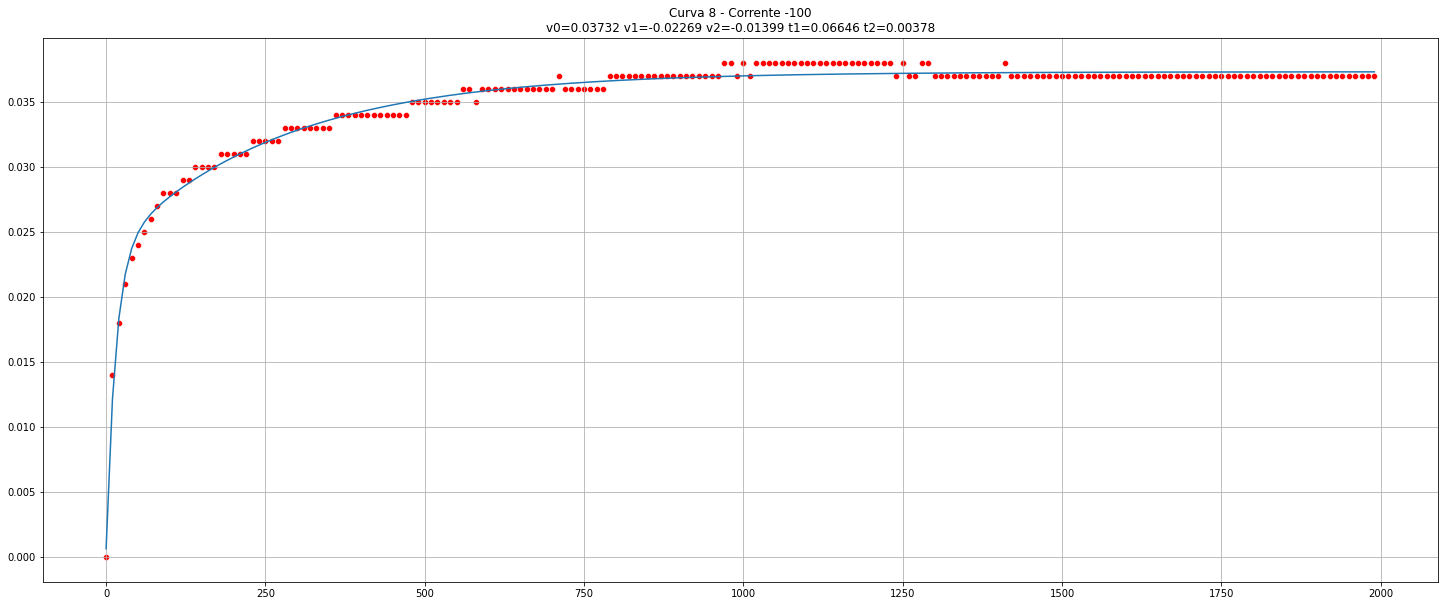

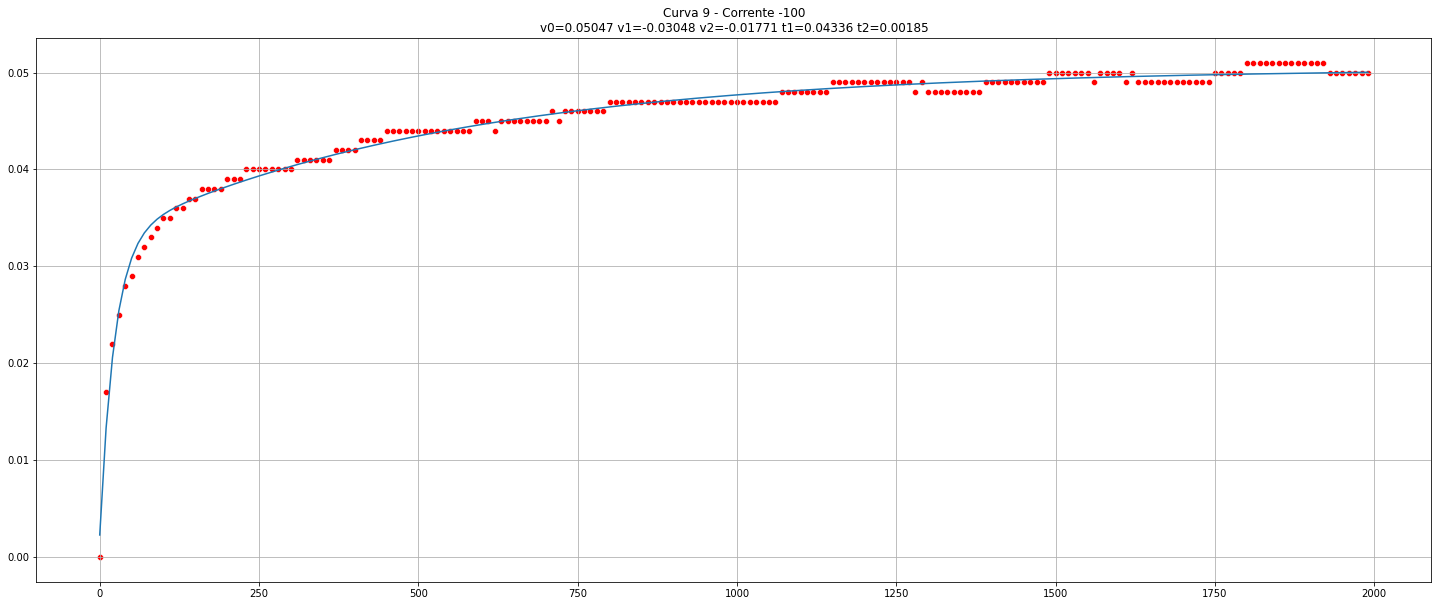

In [6]:
p0 = np.array([ 3.31893375e+00, -2.11580237e-02, -9.80514235e-03,  3.18578442e-02, 2.12246228e-03])+np.random.normal(0, 0.001, 5)

for i, (p1, p2) in enumerate(points):
    t, v, corrente = get_t_v(p1, df_c100)
    sigma = np.array([0]*t.size)
    vals, cov = sp.optimize.curve_fit(f=modelo_2rc, xdata=t, ydata=v, p0=p0)
    p0 = vals+np.random.normal(0, 0.001, 5)

    plt.figure(figsize=(25, 10))
    plt.title(f'Curva {i} - Corrente {corrente:.0f}\nv0={vals[0]:.5f} v1={vals[1]:.5f} v2={vals[2]:.5f} t1={vals[3]:.5f} t2={vals[4]:.5f}')
    sns.scatterplot(y=v, x=t, color='red')
    sns.lineplot(y=modelo_2rc(t, *vals), x=t)
    plt.grid()
    plt.show()
    plt.close()